In [1]:
# Copy from https://www.kaggle.com/ninglee/titanic-data-processing-with-python-0-813-e3ebd7
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "."]).decode("utf8"))
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

id_list = test_data["PassengerId"]
train_data = train_data.drop(['PassengerId'], axis=1)
test_data = test_data.drop(['PassengerId'], axis=1)

In [2]:
def feature_normalization(feat_vector):
    # scala value to [-1, +1]
    max_value = max(feat_vector)
    min_value = min(feat_vector)
    mean_value = feat_vector.mean()
    return (feat_vector - mean_value) / (max_value - min_value)


# It's not reasonable to transfer *Embarked* or *Pclass* into continuous value
def dummy(data, columns):
    for column in columns:
        if column not in data.columns:
            continue
        dummy_data = pd.get_dummies(data[column], drop_first=True)
        # rename columns: column name + 1,2,3
        num = len(dummy_data.loc[1, :])
        dummy_data.columns = [column+str(x+1) for x in range(num)]
        data = pd.concat([data, dummy_data], axis=1)

        data = data.drop(column, axis=1)
    return data

,Fare
Cabin,
0,19.157325
1,17.493135
2,49.281278
3,106.072642


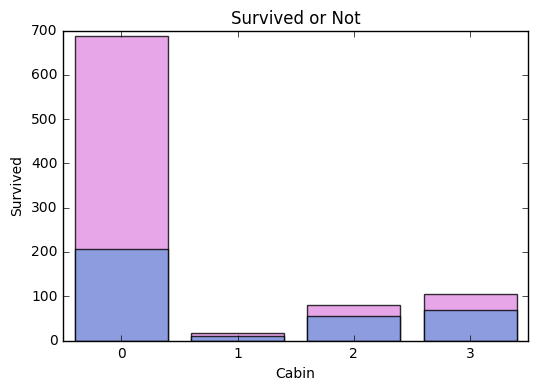

In [3]:
def cabin_extract(data):
    # classify Cabin by fare
    data['Cabin'] = data['Cabin'].fillna('X')
    data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0])
    data['Cabin'] = data['Cabin'].replace(['A', 'D', 'E', 'T'], 'M')
    data['Cabin'] = data['Cabin'].replace(['B', 'C'], 'H')
    data['Cabin'] = data['Cabin'].replace(['F', 'G'], 'L')
    data['Cabin'] = data['Cabin'].map({'X': 0, 'L': 1, 'M': 2, 'H': 3}).astype(int)
    return data

train_data = cabin_extract(train_data)
test_data = cabin_extract(test_data)
# show the connection between Cabin and Survive rate
ax = plt.axes()
data = train_data.groupby(['Cabin'])[['Survived']].count()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='violet', ax=ax)
data = train_data.groupby(['Cabin'])[['Survived']].sum()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='cornflowerblue', ax=ax)
ax.set_title('Survived or Not')
#plt.show()
train_data.groupby(['Cabin'])[['Fare']].mean()  # mean fare of each cabin class

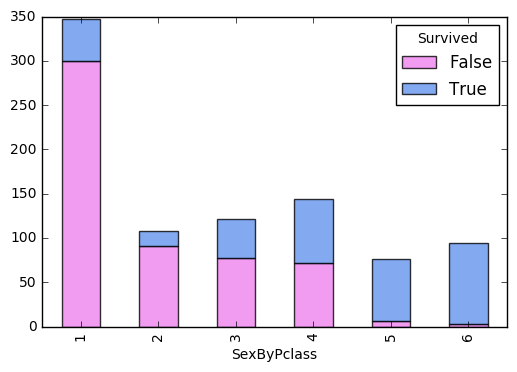

In [4]:
def SexByPclass(data):
    data['Sex'] = data['Sex'].map({'female': 1, 'male':0})
    data['Sex'] = data['Sex'].astype(int)
    data['Pclass'] = data['Pclass'].map({1: 3, 2: 2, 3:1}).astype(int)
    # data['SexByPclass'] = feature_normalization((data['SexTemp'] * data['Pclass']).astype(int))
    data.loc[data['Sex']==0, 'SexByPclass'] = data.loc[data['Sex']==0, 'Pclass']
    data.loc[data['Sex']==1, 'SexByPclass'] = data.loc[data['Sex']==1, 'Pclass'] + 3
    data['SexByPclass'] = data['SexByPclass'].astype(int)
    return data

train_data = SexByPclass(train_data)
test_data = SexByPclass(test_data)
temp = pd.crosstab([train_data.SexByPclass,], train_data.Survived.astype(bool))
temp.plot(kind='bar', stacked=True, color=['violet','cornflowerblue'], alpha=0.8, grid=False)

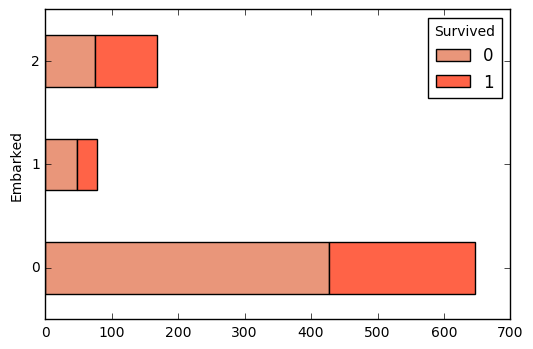

In [5]:
def fill_missing_embarked(data):
    freq_port = data['Embarked'].mode()[0]
    data['Embarked'] = data['Embarked'].fillna(freq_port)
    data['Embarked'] = data['Embarked'].map({'S': 0, 'Q': 1, 'C': 2}).astype(int)
    return data

train_data = fill_missing_embarked(train_data)
test_data = fill_missing_embarked(test_data)
temp = pd.crosstab(train_data.Embarked, train_data.Survived)
temp.plot(kind='barh', stacked=True, color=['darksalmon','tomato'], grid=False)

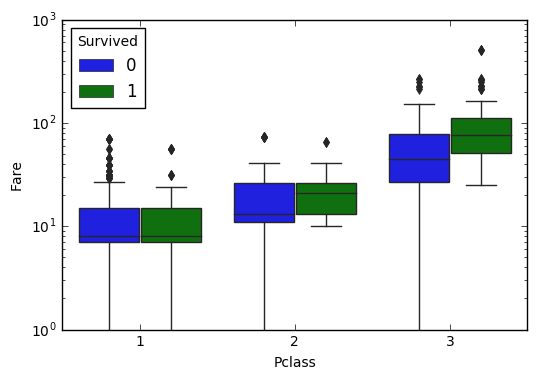

In [6]:
def fare_info(data):
    data.loc[data.Fare.isnull(), 'Fare'] = data['Fare'].mean()
    data['Fare'] = data['Fare'].astype(int)
    data['Fare_stage'] = (data['Fare'] / 10).astype(int)
    return data

train_data = fare_info(train_data)
test_data = fare_info(test_data)
#sns.distplot(train_data['Fare_stage'], kde = True, rug = True)   
#sns.plt.show()

ax = sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=train_data);
ax.set_yscale('log')

train_data = train_data.drop('Fare_stage', axis=1)
test_data = test_data.drop('Fare_stage', axis=1)

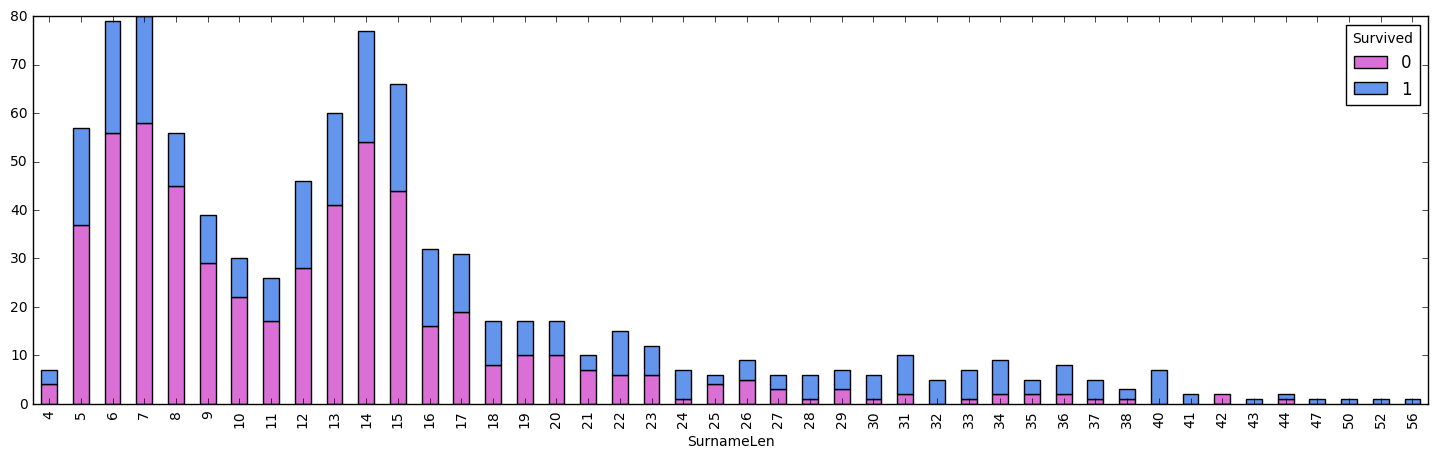

In [7]:
def name_extract(data):
    # extract Title from name
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
    # delete rare title
    data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['Surname'] = data['Name'].apply(lambda x: str(x).split('.')[1].split(' ')[1])
    data['Surname'] = data.Surname.str.replace('(', '')
    title_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_map).astype(int)
    data['SurnameLen'] = data['Name'].apply(lambda x: len(str(x).split('.')[1])).astype(int)
                                            
    return data.drop('Name', axis=1) 



train_data = name_extract(train_data)
test_data = name_extract(test_data)

temp = pd.crosstab(train_data.SurnameLen, train_data.Survived)
temp.plot(kind='bar', stacked=True, color=['orchid','cornflowerblue'], grid=False, figsize=(18, 5))

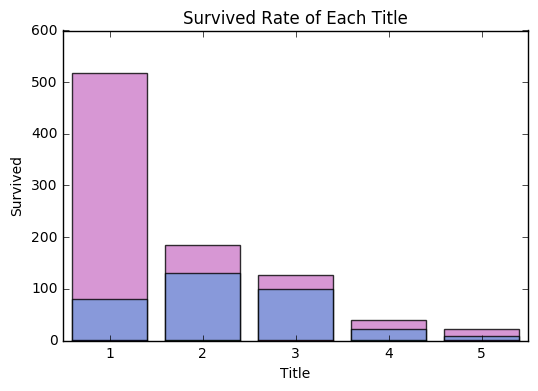

In [8]:
#sns.distplot(train_data['Title'], kde=True, rug=False)
#plt.show()
ax = plt.axes()
data = train_data.groupby(['Title'])[['Survived']].count()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='orchid', ax=ax)
data = train_data.groupby(['Title'])[['Survived']].sum()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, color='cornflowerblue', ax=ax)
ax.set_title('Survived or Not')
#sns.plt.show()
ax = plt.axes()
data = train_data.groupby(['Title'])[['Survived']].mean()
sns.barplot(x=data.index, y=data['Survived'], alpha=0.8, ax=ax)
ax.set_title('Survived Rate of Each Title')
#sns.plt.show()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


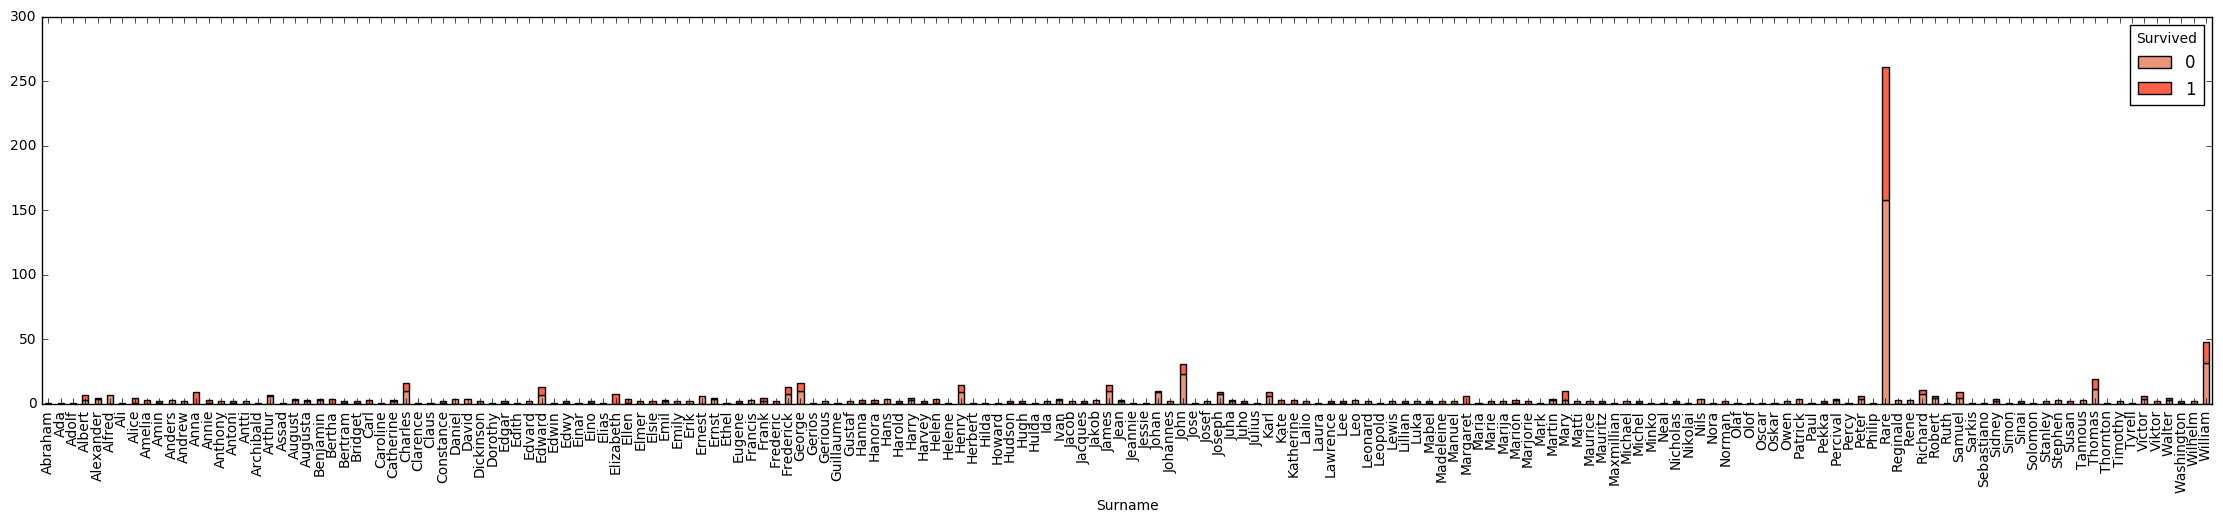

In [9]:
def surname_extract(train, test):
    Survived = train['Survived']
    combine = pd.concat([train_data.drop('Survived',1),test_data])
    combine['CommonSurname'] = np.where(combine.groupby(['Surname'])['Pclass'].transform('count') > 1, 1, 0)
    combine.loc[combine['CommonSurname']==0, 'Surname'] = 'Rare'
    train = combine.iloc[:len(train)]
    train['Survived'] = Survived
    test = combine.iloc[len(train):]
    return  train, test

train_data, test_data = surname_extract(train_data, test_data)
temp = pd.crosstab(train_data.Surname, train_data.Survived)
temp.plot(kind='bar', stacked=True, color=['darksalmon','tomato'], grid=False, figsize=(28, 5))
#I can't find the way to use Surname as its completely sporadic disturbution
train_data = train_data.drop('Surname', axis=1)
test_data = test_data.drop('Surname', axis=1)

In [10]:
def family_info(data):
    data['FamliySize'] = data['SibSp'] + data['Parch'] + 1
    data['Alone'] = data['Alone'] = (data['SibSp'] == 0) & (data['Parch'] == 0)
    data['Alone'] = data['Alone'].astype(int)
    # you should delete linear relation between family-size and sibsp and parch
    return data
    
train_data = family_info(train_data)
test_data = family_info(test_data)

In [11]:
def fill_missing_age(train_set, test_set):
    '''
    combina train and test data set,
    using linear regression to fill missing value of age in two data sets
    return: tuple constructed by train and test data set
    '''
    train_dropped = train_set[['Pclass', 'SibSp', 'Fare', 'Cabin', 'Title', 'FamliySize', 'Alone', 'Age']]
    test_dropped = test_set[['Pclass', 'SibSp', 'Fare', 'Cabin', 'Title', 'FamliySize', 'Alone', 'Age']]
    combine = pd.concat([train_dropped,test_dropped])
    # training regression model
    train = combine[combine.Age.notnull()]
    model = LinearRegression()
    model.fit(train.drop(['Age'], axis=1), train['Age'])
    
    data = combine.loc[combine.Age.isnull()]
    predict_ages = model.predict(data.drop('Age', axis=1))
    combine.loc[combine.Age.isnull(), 'Age'] = predict_ages
    combine['Age'] = combine['Age'].astype(int)
    train_set['Age'] = combine.iloc[:len(train_set)]['Age']
    test_set['Age'] = combine.iloc[len(train_set):]['Age']

    return train_set, test_set

train_data, test_data = fill_missing_age(train_data, test_data)

In [12]:
temp = pd.crosstab(train_data.Age, train_data.Survived)
#sns.kdeplot(train_data['Age'], shade=False, label='Train age distribution')   
#sns.kdeplot(train_data.loc[train_data['Survived']==1, 'Age'], shade=False, label='Survived distribution')   
#sns.kdeplot(test_data['Age'], shade=False, label='Test age distribution')   
#sns.plt.show()

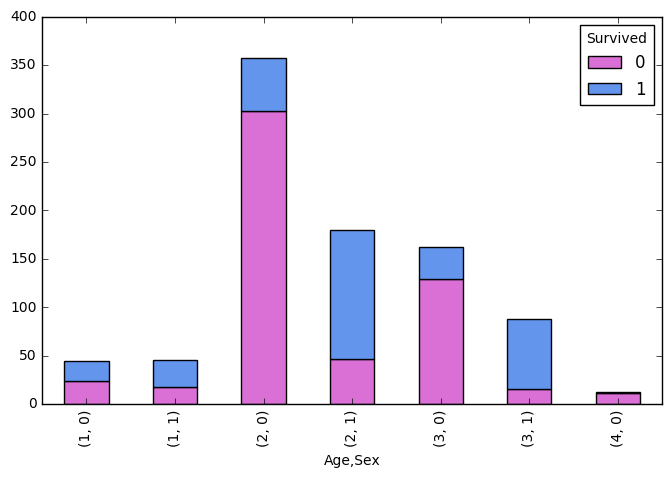

In [13]:
def age_extract(data):
    data['IsChild'] = data['Age'] < 14
    
    data.loc[data['Age'] < 16, 'Age'] = 1
    data.loc[(data['Age'] < 35) & (data['Age'] > 15.9), 'Age'] = 2
    data.loc[(data['Age'] < 64) & (data['Age'] > 34.9), 'Age'] = 3
    data.loc[data['Age'] > 63.9, 'Age'] = 4
    data['Age'] = data['Age'].astype(int)
    return data

train_data = age_extract(train_data)
test_data = age_extract(test_data)
temp = pd.crosstab([train_data.Age, train_data.Sex], train_data.Survived)
temp.plot(kind='bar', stacked=True, color=['orchid','cornflowerblue'], grid=False, figsize=(8, 5))

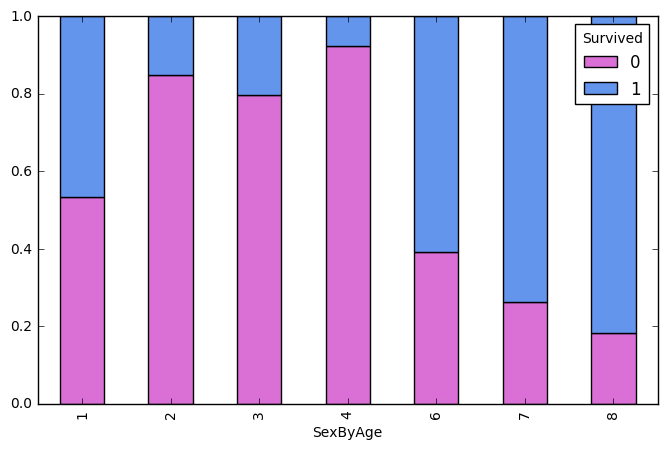

In [14]:
def SexByAge(data):
    data.loc[data['Sex']==0, 'SexByAge'] = data.loc[data['Sex']==0, 'Age']
    data.loc[data['Sex']==1, 'SexByAge'] = data.loc[data['Sex']==1, 'Age'] + 5
    data['SexByAge'] = data['SexByAge'].astype(int)
    return data


train_data = SexByAge(train_data)
test_data = SexByAge(test_data)
temp = pd.crosstab(train_data.SexByAge, train_data.Survived)
temp.div(temp.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['orchid','cornflowerblue'], grid=False, figsize=(8, 5))

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


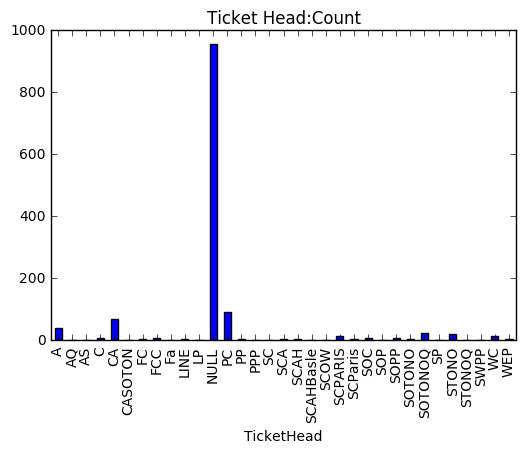

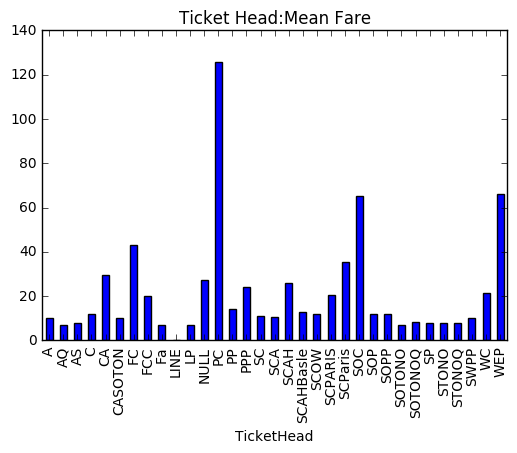

                  Fare  Survived  Count  SurviveRatio
TicketHead                                           
A            10.179487       2.0     39      0.051282
AQ            7.000000       NaN      2           NaN
AS            8.000000       0.0      1      0.000000
C            12.000000       2.0      8      0.250000
CA           29.705882      14.0     68      0.205882
CASOTON      10.000000       0.0      1      0.000000
FC           43.000000       0.0      3      0.000000
FCC          20.222222       4.0      9      0.444444
Fa            7.000000       0.0      1      0.000000
LINE          0.000000       1.0      4      0.250000
LP            7.000000       NaN      1           NaN
NULL         27.397074     254.0    957      0.265413
PC          125.826087      39.0     92      0.423913
PP           14.250000       2.0      4      0.500000
PPP          24.000000       1.0      2      0.500000
SC           11.000000       1.0      2      0.500000
SCA          10.333333      

In [15]:
def ticket_extract(train, test):
    data = pd.concat([train.drop('Survived',1),test])
    Survived = train['Survived']
    data['Ticket'] = data.Ticket.str.replace('.', '')
    data['Ticket'] = data.Ticket.str.replace('/', '')
    data['SharedTicket'] = np.where(data.groupby('Ticket')['Fare'].transform('count') > 1, 1, 0)

    data['TicketNumLen'] = data['Ticket'].apply(lambda x: len(str(x).split(' ')[-1])).astype(int)
    data['Ticket'] = data.Ticket.str.replace(' ', '')
    data['TicketHead'] = data.Ticket.str.extract('(\D*)', expand=False)
    data['TicketHead'] = data['TicketHead'].replace('', 'NULL')
    data = data.drop('Ticket', axis=1)
    train = data.iloc[:len(train)]
    train['Survived'] = Survived
    test = data.iloc[len(train):]
    return  train, test



train_data, test_data = ticket_extract(train_data, test_data)

data_set = pd.concat([train_data.drop('Survived',1),test_data])
temp = data_set.groupby(['TicketHead'])[['Fare']].mean()
temp['Survived'] = train_data.groupby(['TicketHead'])[['Survived']].sum()
temp['Count'] = data_set.groupby(['TicketHead'])['Fare'].count()
temp['SurviveRatio'] = temp['Survived'] / temp['Count']

temp['Count'].plot(kind='bar', title='Ticket Head:Count')
plt.show()
temp['Fare'].plot(kind='bar', title='Ticket Head:Mean Fare')
plt.show()
print(temp)

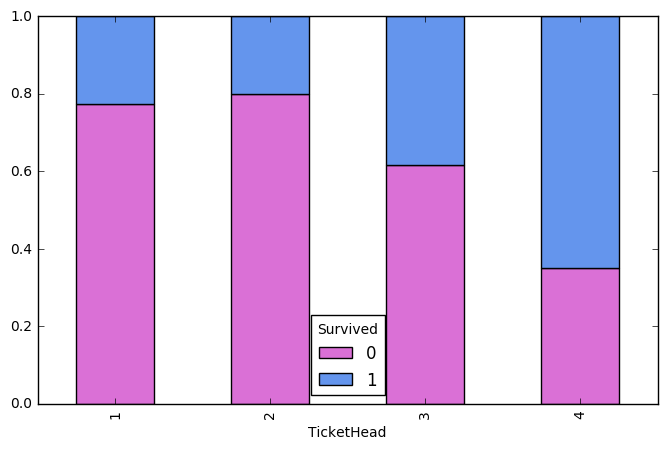

In [16]:
def transfer_ticket_head(data):
    data['TicketHead'] = data['TicketHead'].replace('PC', '4')
    data['TicketHead'] = data['TicketHead'].replace(['FC', 'WEP', 'SOC'], '2')
    data['TicketHead'] = data['TicketHead'].replace(['CA', 'FCC', 'PPP', 'SC', 'SCAH', 'SCPARIS', 'SCParis', 'WC', 'NULL'], '3')
    classes = ['A', 'AS', 'AQ','C', 'CASOTON', 'Fa', 'LINE', 'LP','PP', 'SCA', 'SCAHBasle', 'SCOW' ,'SOP', 'SOPP', 'SOTONO', 'SOTONOQ', 
               'SP', 'STONO', 'STONOQ', 'SWPP']
    data['TicketHead'] = data['TicketHead'].replace(classes, '1')
    data['TicketHead'] = data['TicketHead'].astype(int)
    return data

train_data = transfer_ticket_head(train_data)
test_data = transfer_ticket_head(test_data)
temp = pd.crosstab(train_data.TicketHead, train_data.Survived)
temp.div(temp.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['orchid','cornflowerblue'], grid=False, figsize=(8, 5))

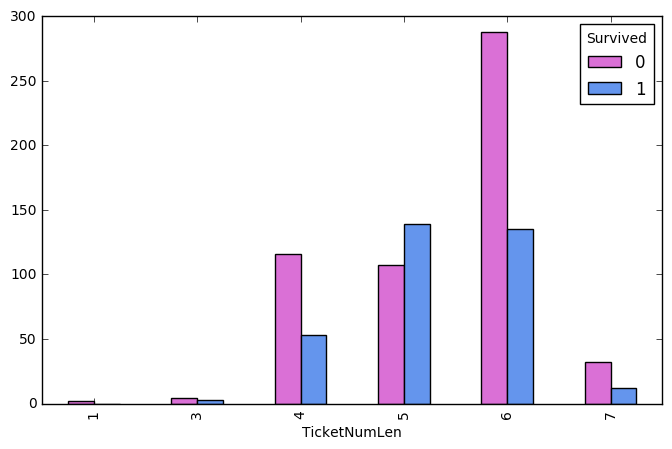

In [17]:
temp = pd.crosstab(train_data.TicketNumLen, train_data.Survived)
temp.plot(kind='bar', color=['orchid','cornflowerblue'], grid=False, figsize=(8, 5))
plt.show()

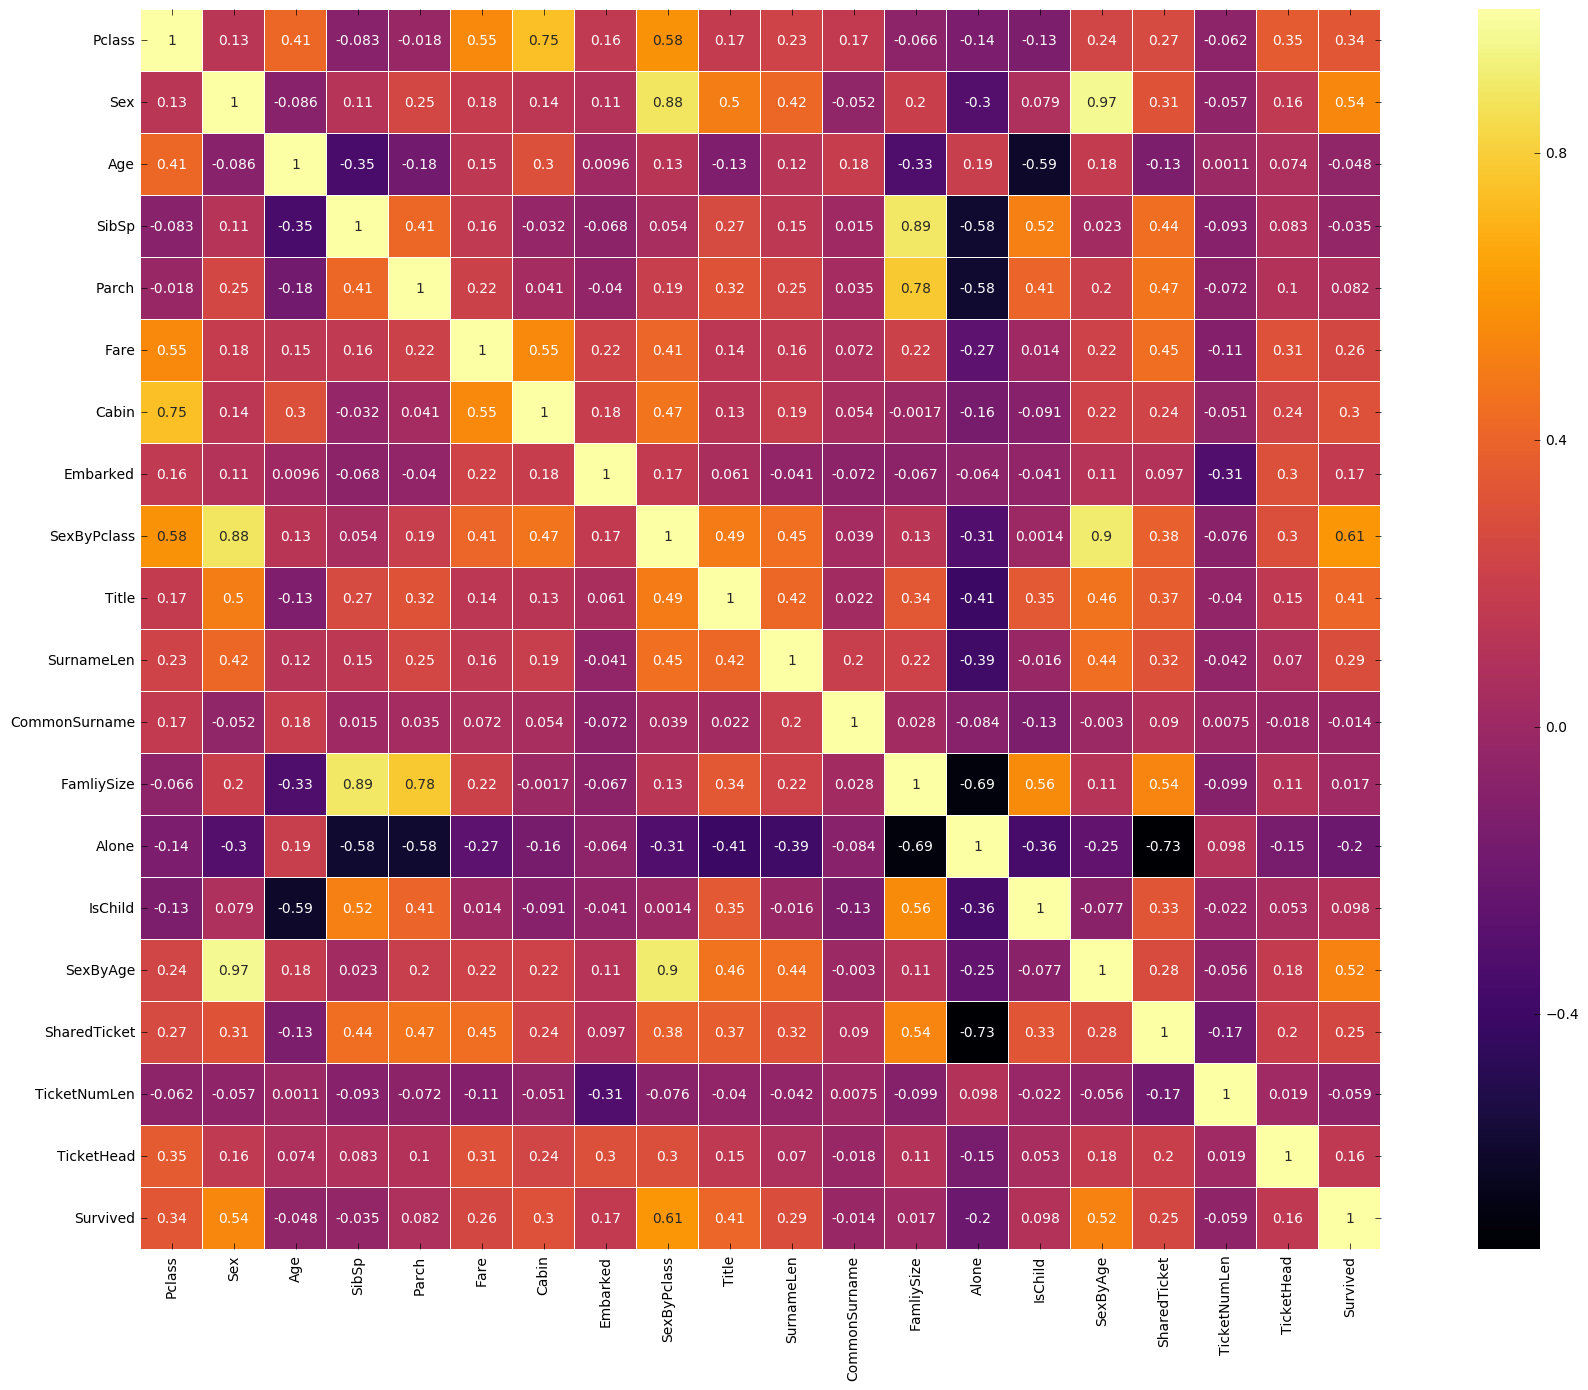

In [18]:
corr = train_data.corr()
f, ax = plt.subplots(figsize=(25,16))
#sns.plt.yticks(fontsize=18)
#sns.plt.xticks(fontsize=18)

sns.heatmap(corr, cmap='inferno', linewidths=0.1,vmax=1.0, square=True, annot=True)

In [19]:
combine = pd.concat([train_data.drop('Survived', axis=1), test_data])
combine['EmbarkedTemp'] = combine['Embarked'].map({0: 'S', 1: 'Q', 2: 'C'})
plotVars = ['Fare', 'Cabin', 'Pclass']
sns.set()
#sns.pairplot(combine, vars=plotVars, hue='EmbarkedTemp', kind='reg')
#sns.plt.show()
del combine

In [20]:
# Embarked should be transformed to one-hot variable
train_data = dummy(train_data, ['Embarked'])
test_data = dummy(test_data, ['Embarked'])

In [21]:
# search for the best parameters of random forest
def parameter_evaluate(data):
    clf_ev = RandomForestClassifier()
    x, y = data.drop(['Survived'], axis=1), data['Survived']
    parameters = {'n_estimators': [100, 300], 'max_features': [3, 4, 5, 'auto'],
                  'min_samples_leaf': [9, 10, 12], 'random_state': [7]}
    grid_search = GridSearchCV(estimator=clf_ev, param_grid=parameters, cv=10, scoring='accuracy')
    print("parameters:")
    # train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
    grid_search.fit(x, y)
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    bsp = grid_search.best_estimator_.get_params()  # the dict of parameters with best score
    for param_name in sorted(bsp.keys()):
        print("\t%s: %r" % (param_name, bsp[param_name]))
    return bsp

# parameters = parameter_evaluate(train_data)  
# we don't need to search everytime after getting best parameters
parameters = {'n_estimators': 100, 'max_features': 5, 'min_samples_leaf': 10, 'random_state': 7}
rf = RandomForestClassifier(**parameters)
rf.fit(train_data.drop(['Survived'], axis=1), train_data['Survived'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

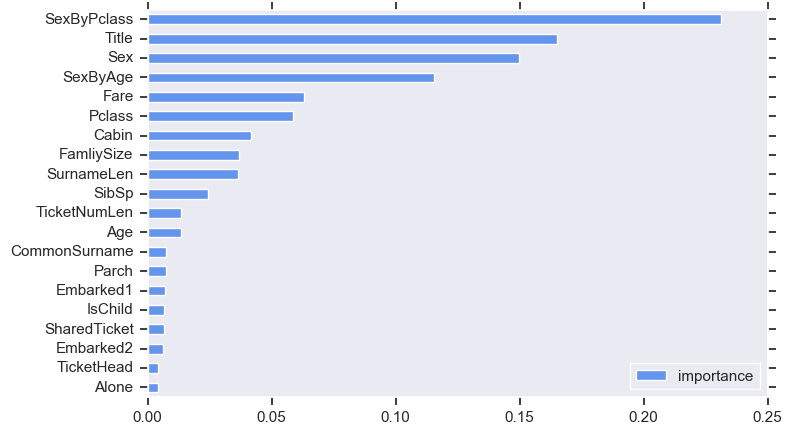

In [22]:
names = train_data.drop(['Survived'], axis=1).columns
ratios = rf.feature_importances_

feature_important = pd.DataFrame(index=names, data=ratios, columns=['importance'])
feature_important = feature_important.sort_values(by=['importance'], ascending=True)
feature_important.plot(kind='barh', stacked=True, color=['cornflowerblue'], grid=False, figsize=(8, 5))

In [23]:
lr = LogisticRegression(random_state=7)
lr.fit(train_data.drop(['Survived'], axis=1), train_data['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
knn = KNeighborsClassifier()
knn.fit(train_data.drop(['Survived'], axis=1), train_data['Survived'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [25]:
eclf1 = VotingClassifier(estimators=[
        ('lr', lr), ('rf', rf), ('knn', knn)], voting='soft', weights=[1, 2, 1])
eclf1 = eclf1.fit(train_data.drop(['Survived'], axis=1), train_data['Survived'])
results = eclf1.predict(test_data)
output = pd.DataFrame({'PassengerId': id_list, "Survived": results})
output.to_csv('./prediction.csv', index=False)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
## test on test data from kaggle

standard_ = pd.read_csv('submission_cheating.csv')
np.sum(standard_['Survived'] ==results)/len(results)

0.7942583732057417

In [27]:
print("81.339 全球排名%0.2f - %0.2f"%(100*730/16501,100*574/16501),'%')

81.339 全球排名4.42 - 3.48 %
